In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load
ds_predictors = xr.open_dataset("predictors.nc")  # Predictors dataset (8 variables)

# Define new latitude and longitude grid (0.25° resolution)
new_lats = np.arange(-90, 90.25, 0.25)  # Latitudes from -90 to 90
new_lons = np.arange(-180, 177.75, 0.25)  # Longitudes from -180 to 177.5

# interpolation (bilinear regridding)
ds_predictors_high_res = ds_predictors.interp(latitude=new_lats, longitude=new_lons, method="linear")

# Save
ds_predictors_high_res.to_netcdf("predictors_high_res.nc")

# Print shapes before and after interpolation
print("Original Shape:", ds_predictors[list(ds_predictors.data_vars)[0]].shape)
print("New Shape:", ds_predictors_high_res[list(ds_predictors.data_vars)[0]].shape)

Original Shape: (504, 73, 144)
New Shape: (504, 721, 1431)


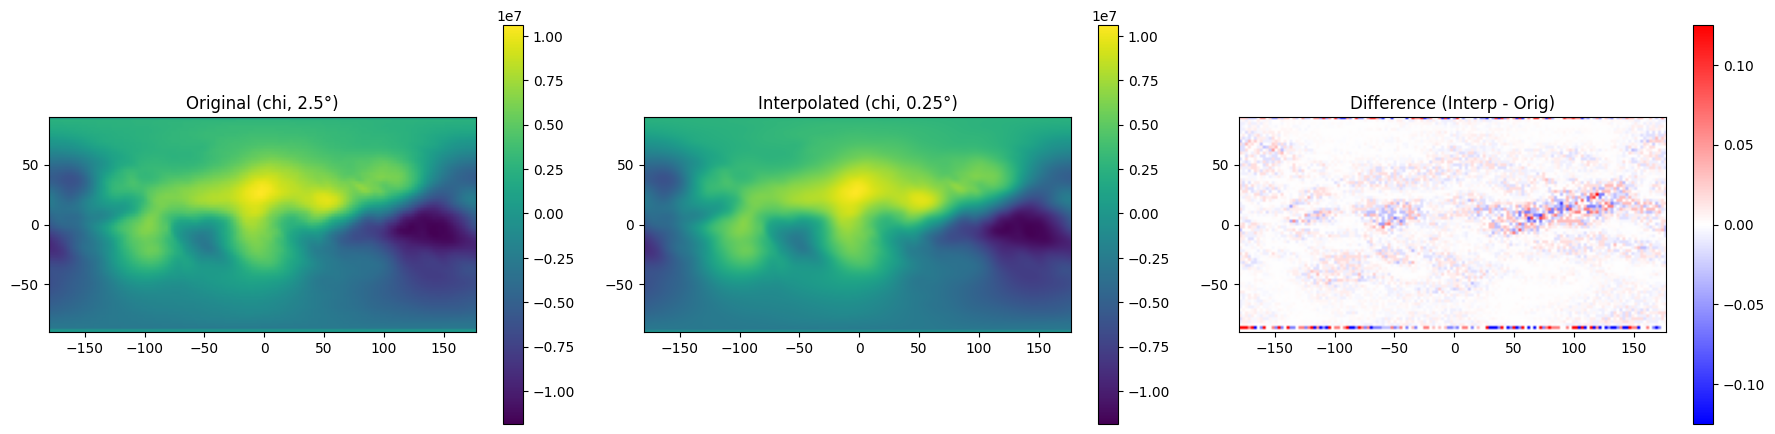

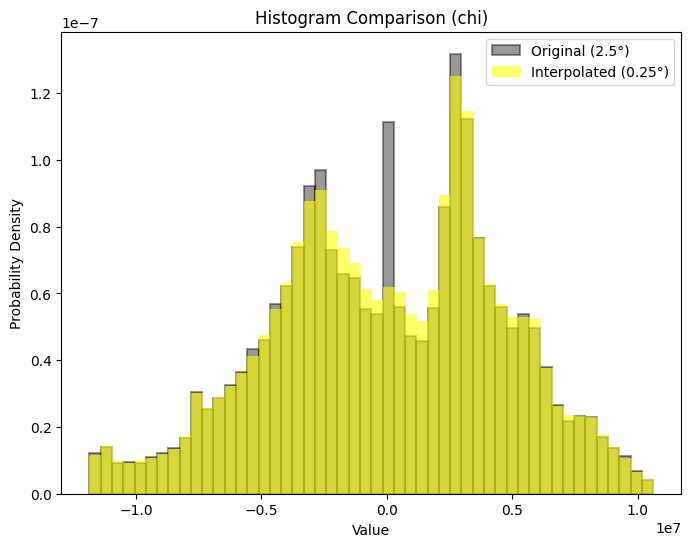

Original chi - Mean: -14562.1914, Std: 4588202.0000, Min: -11859652.0000, Max: 10616659.0000
Interpolated chi - Mean: 12124.5463, Std: 4605229.9654, Min: -11859652.0000, Max: 10616658.9980


In [5]:
# Load original (low-res) and high-res datasets
ds_orig = xr.open_dataset("predictors.nc")  # Original 2.5° resolution
ds_interp = xr.open_dataset("predictors_high_res.nc")  # Interpolated 0.25° resolution

# Select a variable and time step for comparison
var_name = list(ds_orig.data_vars)[5]  # Choose first variable
time_step = 0  # Select a specific time index

# Extract data
data_orig = ds_orig[var_name].isel(time=time_step)
data_interp = ds_interp[var_name].isel(time=time_step)

# Plot original and interpolated data
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Data
im1 = axes[0].imshow(data_orig, cmap="viridis", origin="lower", extent=[-180, 177.5, -90, 90])
axes[0].set_title(f"Original ({var_name}, 2.5°)")
fig.colorbar(im1, ax=axes[0], shrink=0.7)

# Interpolated Data
im2 = axes[1].imshow(data_interp, cmap="viridis", origin="lower", extent=[-180, 177.5, -90, 90])
axes[1].set_title(f"Interpolated ({var_name}, 0.25°)")
fig.colorbar(im2, ax=axes[1], shrink=0.7)

# Difference Map (Error)
diff = data_interp.interp_like(data_orig) - data_orig 
im3 = axes[2].imshow(diff, cmap="bwr", origin="lower", extent=[-180, 177.5, -90, 90])
axes[2].set_title(f"Difference (Interp - Orig)")
fig.colorbar(im3, ax=axes[2], shrink=0.7)

plt.tight_layout()
plt.show()

# Compare Histograms (Normalize by Density)
plt.figure(figsize=(8, 6))

# Original Data Histogram (2.5°)
plt.hist(data_orig.values.flatten(), bins=50, alpha=0.4, label="Original (2.5°)", density=True, color="black", edgecolor="black", linewidth=1.5)

# Interpolated Data Histogram (0.25°)
plt.hist(data_interp.values.flatten(), bins=50, alpha=0.6, label="Interpolated (0.25°)", density=True, color="yellow", histtype='stepfilled', edgecolor="yellow", linewidth=0.5)

plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title(f"Histogram Comparison ({var_name})")
plt.legend()
plt.show()

print(f"Original {var_name} - Mean: {data_orig.mean().item():.4f}, Std: {data_orig.std().item():.4f}, Min: {data_orig.min().item():.4f}, Max: {data_orig.max().item():.4f}")
print(f"Interpolated {var_name} - Mean: {data_interp.mean().item():.4f}, Std: {data_interp.std().item():.4f}, Min: {data_interp.min().item():.4f}, Max: {data_interp.max().item():.4f}")

In [4]:
ds = xr.open_dataset("predictors_high_res.nc")

time_values = ds['time'].values

# Extract month from time values
months = np.array([t.month for t in pd.to_datetime(time_values)])

# Normalize the month to [0, 1)
normalized_month = months / 12.0

# Calculate sine and cosine
sine_of_year = np.sin(2 * np.pi * normalized_month)
cosine_of_year = np.cos(2 * np.pi * normalized_month)

# Normalize sine and cosine to [0, 1)
sine_of_year_normalized = (sine_of_year + 1) / 2  
cosine_of_year_normalized = (cosine_of_year + 1) / 2


# Broadcast sine and cosine values to match lat/lon dimensions
ds['sine_of_year'] = (('time', 'latitude', 'longitude'), 
                      np.broadcast_to(sine_of_year_normalized[:, None, None], (len(sine_of_year), len(ds.latitude), len(ds.longitude))))
ds['cosine_of_year'] = (('time', 'latitude', 'longitude'), 
                        np.broadcast_to(cosine_of_year_normalized[:, None, None], (len(cosine_of_year), len(ds.latitude), len(ds.longitude))))
ds = ds.drop_vars("level")
ds = ds.transpose("latitude", "longitude", "time")
ds.to_netcdf('final_predictors_0.25d.nc')

In [5]:
# add tp 
ds = xr.open_dataset('final_predictors_0.25d.nc')
ds2 = xr.open_dataset('tp.nc')
ds2 = ds2.transpose("latitude", "longitude", "time")
ds2_reindexed = ds2.reindex(latitude=ds.latitude, longitude=ds.longitude, fill_value=float('nan'))
ds = xr.merge([ds, ds2_reindexed])

# add masks for sst
variable_name = 'sst'
mask = ds[variable_name].isnull()  
mask = (~mask).astype(np.float32)  # 1 for ocean (valid), 0 for land (null)
mask = mask.min(dim='time')
ds['sst_mask'] = mask

variable_name = 'pottmp'
mask = ds[variable_name].isnull()  
mask = (~mask).astype(np.float32)
mask = mask.min(dim='time')
ds['pottmp_mask'] = mask

variable_name = 'tp'
mask = ds[variable_name].isnull() 
mask = (~mask).astype(np.float32)
mask = mask.min(dim='time')
ds['tp_mask'] = mask

In [6]:
ds

<xarray.Dataset> Size: 44GB
Dimensions:         (latitude: 721, longitude: 1431, time: 504)
Coordinates:
  * time            (time) datetime64[ns] 4kB 1982-01-01 ... 2023-12-01
  * latitude        (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * longitude       (longitude) float64 11kB -180.0 -179.8 ... 177.2 177.5
Data variables: (12/14)
    sst             (latitude, longitude, time) float64 4GB nan ... -2.98e-08
    thickness       (latitude, longitude, time) float64 4GB ...
    pottmp          (latitude, longitude, time) float64 4GB 0.0 0.0 ... 0.0 0.0
    pr_wtr          (latitude, longitude, time) float64 4GB ...
    lftx4           (latitude, longitude, time) float64 4GB ...
    chi             (latitude, longitude, time) float64 4GB ...
    ...              ...
    sine_of_year    (latitude, longitude, time) float64 4GB ...
    cosine_of_year  (latitude, longitude, time) float64 4GB ...
    tp              (latitude, longitude, time) float32 2GB nan nan ... nan nan
    sst_mask        (latitude, longitude) float32 4MB 0.0 0.0 0.0 ... 1.0 1.0
    pottmp_mask     (latitude, longitude) float32 4MB 1.0 1.0 1.0 ... 1.0 1.0
    tp_mask         (latitude, longitude) float32 4MB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [7]:
# generate batches
time_values = ds.time.values
num_batches = len(time_values) - 5  # Sliding window of 6 time steps

for batch in range(num_batches):
    start_idx, end_idx = batch, batch + 6
    batch_ds = ds.isel(time=slice(start_idx, end_idx)) 

    start_date = str(time_values[start_idx])[:10].replace("-", "")
    end_date = str(time_values[end_idx - 1])[:10].replace("-", "")

    filename = f"batch-{batch+1:03d}-{start_date}-{end_date}.nc"

    # Save to NetCDF
    batch_ds.to_netcdf(f'batches/{filename}')
    print(f"Saved: {filename}")

Saved: batch-001-19820101-19820601.nc
Saved: batch-002-19820201-19820701.nc
Saved: batch-003-19820301-19820801.nc
Saved: batch-004-19820401-19820901.nc
Saved: batch-005-19820501-19821001.nc
Saved: batch-006-19820601-19821101.nc
Saved: batch-007-19820701-19821201.nc
Saved: batch-008-19820801-19830101.nc
Saved: batch-009-19820901-19830201.nc
Saved: batch-010-19821001-19830301.nc
Saved: batch-011-19821101-19830401.nc
Saved: batch-012-19821201-19830501.nc
Saved: batch-013-19830101-19830601.nc
Saved: batch-014-19830201-19830701.nc
Saved: batch-015-19830301-19830801.nc
Saved: batch-016-19830401-19830901.nc
Saved: batch-017-19830501-19831001.nc
Saved: batch-018-19830601-19831101.nc
Saved: batch-019-19830701-19831201.nc
Saved: batch-020-19830801-19840101.nc
Saved: batch-021-19830901-19840201.nc
Saved: batch-022-19831001-19840301.nc
Saved: batch-023-19831101-19840401.nc
Saved: batch-024-19831201-19840501.nc
Saved: batch-025-19840101-19840601.nc
Saved: batch-026-19840201-19840701.nc
Saved: batch

In [8]:
ds = ds.drop_vars(["tp_mask", "sst_mask", "pottmp_mask"])

# Compute mean and standard deviation over all dimensions (lat, lon, time)
mean_value = ds.mean(dim=("latitude", "longitude", "time"), keep_attrs=True)
std_value = ds.std(dim=("latitude", "longitude", "time"), keep_attrs=True)

mean_value.to_netcdf("means.nc")
std_value.to_netcdf("std.nc")